#Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import

In [ ]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 39.2 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Importing ImageDataGenerator for augmentation
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip, RandomBrightnessContrast
import random

#Dataset Utilities

##Load Dataset

In [ ]:
def load_dataset(path):
  images = sorted(glob(os.path.join(path, "train/images/*")))
  masks = sorted(glob(os.path.join(path, "train/masks/*")))
  return images, masks

##Create Directory

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

#Create Target Directories for Augmentation

In [ ]:
# Specify the target directory in your Google Drive
base_dir = "/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/non-aug"

# Ensure the base directory exists
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Create subdirectories for train, test, and val
for item in ["train", "test", "val"]:
    os.makedirs(os.path.join(base_dir, item, "images"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, item, "masks"), exist_ok=True)

print(f"Directories created in: {base_dir}")


Directories created in: /content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/non-aug


#Save Dataset with Augmentation

In [ ]:
def save_dataset(images, masks, save_dir, augment=False):
    """
    Save images and masks into the specified directory with optional augmentations.

    Args:
        images (list): List of file paths for images.
        masks (list): List of file paths for masks.
        save_dir (str): Base directory to save images and masks.
        augment (bool): Whether to perform augmentations.
    """
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "masks"), exist_ok=True)

    for x, y in tqdm(zip(images, masks), total=len(images), desc="Processing dataset"):
        name = os.path.splitext(os.path.basename(x))[0]  # Extract file name without extension

        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        aug_x, aug_y = [x], [y]

        if augment:
            # Randomly choose one augmentation
            augmentations = [
                HorizontalFlip(p=1.0),
                RandomBrightnessContrast(p=1.0)
            ]

            # Apply a random augmentation
            chosen_aug = random.choice(augmentations)
            augmented = chosen_aug(image=x, mask=y)
            aug_x.append(augmented["image"])
            aug_y.append(augmented["mask"])

        for idx, (ax, ay) in enumerate(zip(aug_x, aug_y)):
            aug_name = f"{name}_{idx}.png"
            img_path = os.path.join(save_dir, "images", aug_name)
            mask_path = os.path.join(save_dir, "masks", aug_name)

            cv2.imwrite(img_path, ax)
            cv2.imwrite(mask_path, ay)

    print(f"Dataset saved to {save_dir}")

#Process and Save Train, Validation, and Test Sets

##Save Training Set

In [ ]:
train_x = sorted(glob("/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/non-aug/train/images/*"))
train_y = sorted(glob("/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/non-aug/train/masks/*"))

save_dataset(train_x, train_y, save_dir="/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/train", augment=True)

Processing dataset: 100%|██████████| 1436/1436 [27:53<00:00,  1.17s/it]

Dataset saved to /content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/train


##Save Validation Set

In [ ]:
valid_x = sorted(glob("/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/non-aug/val/images/*"))
valid_y = sorted(glob("/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/non-aug/val/masks/*"))

save_dataset(valid_x, valid_y, save_dir="/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/val", augment=False)

Processing dataset: 100%|██████████| 413/413 [07:23<00:00,  1.07s/it]

Dataset saved to /content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/val


##Save Test Set

In [ ]:
test_x = sorted(glob("/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/non-aug/test/images/*"))
test_y = sorted(glob("/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/non-aug/test/masks/*"))

save_dataset(test_x, test_y, save_dir="/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/test", augment=False)

Processing dataset: 100%|██████████| 223/223 [04:17<00:00,  1.16s/it]

Dataset saved to /content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/test


#Seeding

In [ ]:
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

#Hyperparameters

In [ ]:
# Batch size: number of images processed at once during training
batch_size = 32

# Learning rate: controls how much model weights are updated
lr = 1e-4

# Number of epochs: complete passes through the dataset during training
epochs = 50

# Input image dimensions
height = 512
width = 512

#Path

In [ ]:
dataset_path = '/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug'

files_dir = '/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/files'
model_file = '/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/files/unet.keras'
log_file = '/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/files/logs.csv'

#Creating Folder

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

create_dir(files_dir)

#Building UNET

##Conv Block

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

##Encoder Block

In [ ]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

##Decoder Block

In [ ]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

##UNET

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)  # Define input layer with the given shape

    """ Encoder """
    # Encoding path: extract features and downsample
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """ Bridge """
    # Bridge: deepest layer connecting encoder and decoder
    b1 = conv_block(p4, 1024)

    """ Decoder """
    # Decoding path: upsample and concatenate with skip connections
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer: use a 1x1 convolution with sigmoid for binary segmentation
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    # Build and return the U-Net model
    model = Model(inputs, outputs, name="UNET")
    return model

#IoU Coef and Loss

In [ ]:
smooth = 1e-15

def iou_coef(y_true, y_pred):
  y_true = tf.keras.layers.Flatten()(y_true)
  y_pred = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
  return (intersection + smooth) / (union + smooth)

def iou_loss(y_true, y_pred):
  return 1.0 - iou_coef(y_true, y_pred)

#Dataset Pipeline

##Loading the Training and Validation Dataset

In [ ]:
def load_data(path):
    train_x = sorted(glob(f"{path}/train/images/*"))
    train_y = sorted(glob(f"{path}/train/masks/*"))

    valid_x = sorted(glob(f"{path}/val/images/*"))
    valid_y = sorted(glob(f"{path}/val/masks/*"))
    return (train_x, train_y), (valid_x, valid_y)

##Reading Images

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (512, 512))  # Resize to 512x512
    x = x / 255.0  # Normalize the image
    return x

##Reading Masks

In [ ]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512, 512))  # Resize to 512x512
    x = x / 255.0  # Normalize the mask
    x = np.expand_dims(x, axis=-1)  # Add an extra dimension for channels
    return x

##tf.data pipeline

In [ ]:
def tf_parse(x, y):
    # Define a helper function to read and process the image and mask
    def _parse(x, y):
        x = read_image(x)  # Load and preprocess the image
        y = read_mask(y)   # Load and preprocess the mask
        return x, y

    # Use tf.numpy_function to wrap the parsing function for TensorFlow compatibility
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])

    # Set the expected output shapes for the tensors
    x.set_shape([height, width, 3])  # Set shape for the image (height, width, channels)
    y.set_shape([height, width, 1])  # Set shape for the mask (height, width, 1 channel)

    return x, y  # Return the processed image and mask

In [ ]:
def tf_dataset(x, y, batch=32):
    # Create a TensorFlow dataset from the input image and mask tensors
    dataset = tf.data.Dataset.from_tensor_slices((x, y))

    # Apply the tf_parse function to each (image, mask) pair in the dataset
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the dataset into specified sizes for training
    dataset = dataset.batch(batch)

    # Prefetch data to improve performance by preparing the next batch while the current batch is being processed
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset  # Return the prepared dataset

#Training

In [ ]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 2872 - 2872
Valid: 413 - 413


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [ ]:
for x, y in train_dataset:
  print(x.shape, y.shape)

In [ ]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [ ]:
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512, 512, 64)   │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 128)  │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)       

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
model.compile(loss=iou_loss, optimizer=Adam(lr), metrics=[iou_coef])

In [ ]:
# Define callbacks for training the model
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),  # Save model based on validation loss
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),  # Reduce learning rate when validation loss plateaus
    CSVLogger(log_file),  # Log training progress and append to existing file
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)  # Stop training if validation loss doesn't improve
]

In [ ]:
# Define callbacks for training the model
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
# Train the model using the training and validation datasets for a specified number of epochs with defined callbacks
model.fit(
    train_dataset,            # Training dataset
    validation_data=valid_dataset,  # Validation dataset to monitor performance
    epochs=epochs,           # Number of epochs to train the model
    callbacks=callbacks       # List of callbacks for monitoring and improving training
)

#Loading and Evaluating the Pre-trained U-Net Model on Validation Dataset

In [ ]:
# Load the pre-trained U-Net model with the custom iou_loss and iou_coef functions
model = load_model(
    '/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/files_new/unet.keras',
    custom_objects={'iou_loss': iou_loss, 'iou_coef': iou_coef}
)

# Evaluate the model on the validation dataset
model.evaluate(valid_dataset)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - iou_coef: 0.8543 - loss: 0.1457


[0.13373123109340668, 0.8660926818847656]

#Plot Training and Validation Loss

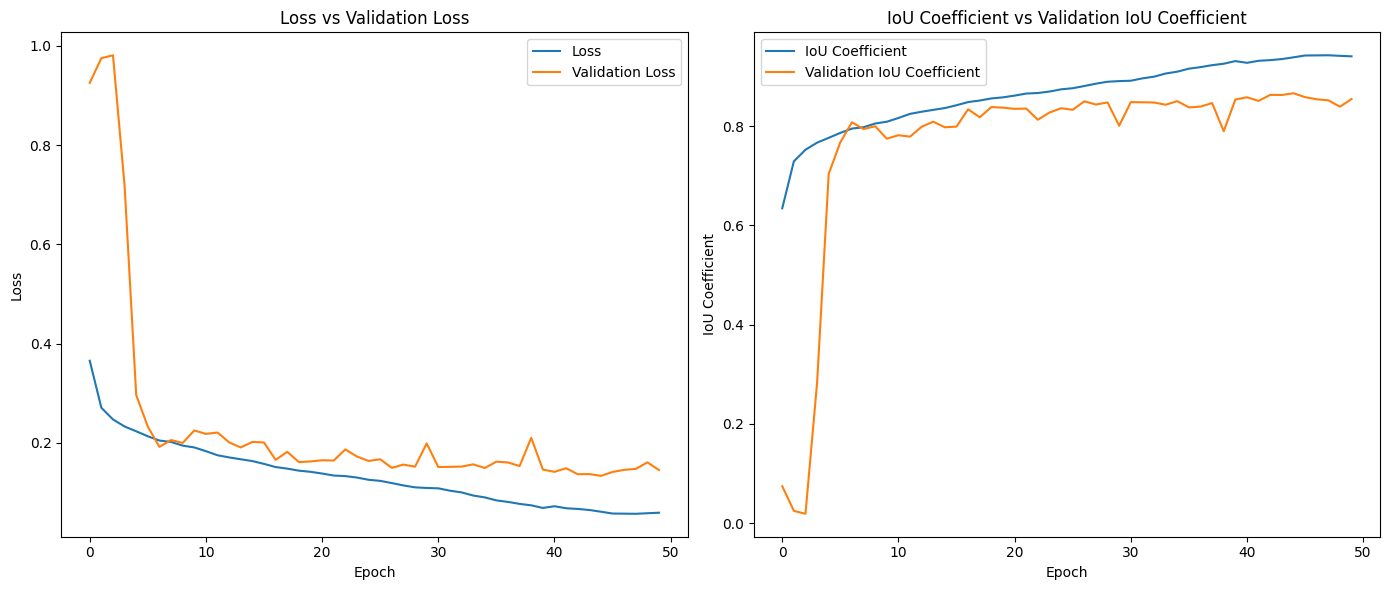

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the logs
logs = pd.read_csv('/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/files_new/logs.csv')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Loss on the first subplot
axes[0].plot(logs['epoch'], logs['loss'], label='Loss')
axes[0].plot(logs['epoch'], logs['val_loss'], label='Validation Loss')
axes[0].set_title('Loss vs Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot IoU Coefficient on the second subplot
axes[1].plot(logs['epoch'], logs['iou_coef'], label='IoU Coefficient')
axes[1].plot(logs['epoch'], logs['val_iou_coef'], label='Validation IoU Coefficient')
axes[1].set_title('IoU Coefficient vs Validation IoU Coefficient')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU Coefficient')
axes[1].legend()

# Display the plot
plt.tight_layout()
plt.show()

#Testing

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
import random

# Load your trained U-Net model
model = load_model(
    '/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/files_new/unet.keras',
    custom_objects={'iou_loss': iou_loss, 'iou_coef': iou_coef}
)

def preprocess_image(image):
    # Resize to the expected input size (512, 512)
    image = cv2.resize(image, (512, 512))  # Note: (width, height) format
    # Normalize the image (if necessary)
    image = image / 255.0  # Scale pixel values to [0, 1]
    # Expand dimensions to match model input shape
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def display_predictions(image_paths):
    for image_path in image_paths:
        # Read the image
        original_image = cv2.imread(image_path)

        # Preprocess the image
        input_image = preprocess_image(original_image)

        # Make predictions
        predicted_mask = model.predict(input_image)

        # Debugging outputs
        print("Processing Image:", image_path)
        print("Input Image Shape:", input_image.shape)
        print("Predicted Mask Shape:", predicted_mask.shape)
        print("Predicted Mask Unique Values:", np.unique(predicted_mask))

        # Handle binary segmentation
        predicted_mask = predicted_mask[0].squeeze()  # Remove batch and channel dimensions

        # Thresholding
        threshold = 0.1  # Adjust threshold as needed
        binary_mask = (predicted_mask > threshold).astype(np.uint8)

        # Resize binary mask to match original image size if necessary
        binary_mask_resized = cv2.resize(binary_mask, (original_image.shape[1], original_image.shape[0]))

        # Create an image with the segmented area in color and the rest in grayscale
        grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        grayscale_background = cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2BGR)

        # Combine the color-segmented area with the grayscale background
        color_segmented_image = np.where(binary_mask_resized[..., None] == 1, original_image, grayscale_background)

        # Display the results
        plt.figure(figsize=(20, 8))  # Set the figure size

        # Original image
        plt.subplot(1, 4, 1)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Predicted segmentation mask
        plt.subplot(1, 4, 2)
        plt.title('Predicted Segmentation Mask')
        plt.imshow(binary_mask_resized, cmap='gray')  # Display the binary mask
        plt.axis('off')

        # Predicted probability map (optional, can show raw predicted mask)
        predicted_mask_scaled = (predicted_mask * 255).astype(np.uint8)
        plt.subplot(1, 4, 3)
        plt.title('Predicted Probability Map')
        plt.imshow(predicted_mask_scaled, cmap='jet')  # Display the predicted probability map
        plt.axis('off')

        # Segmented area in color with grayscale background
        plt.subplot(1, 4, 4)
        plt.title('Segmented Area in Color with Grayscale Background')
        plt.imshow(cv2.cvtColor(color_segmented_image, cv2.COLOR_BGR2RGB))  # Display the combined image
        plt.axis('off')

        plt.show()

# Path to the directory containing test images
test_images_dir = '/content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/test/images'

# Get all image file paths from the directory
all_image_paths = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select 10 images
random_image_paths = random.sample(all_image_paths, 10)

# Display predictions for the selected images
display_predictions(random_image_paths)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import ipywidgets as widgets
from IPython.display import display

# Load your trained U-Net model
model = load_model(
    '//content/drive/MyDrive/Evangeline_Watch_Dataset/Processed/aug/files_new/unet.keras',
    custom_objects={'iou_loss': iou_loss, 'iou_coef': iou_coef}
)

def preprocess_image(image):
    # Resize to the expected input size (512, 512)
    image = cv2.resize(image, (512, 512))  # Note: (width, height) format
    # Normalize the image (if necessary)
    image = image / 255.0  # Scale pixel values to [0, 1]
    # Expand dimensions to match model input shape
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def upload_and_predict(change):
    # Get the uploaded image
    uploaded_image = change['new']

    if uploaded_image:
        for filename in uploaded_image:
            # Read the image data from the uploaded file
            image_data = uploaded_image[filename]['content']
            # Convert to a NumPy array
            nparr = np.frombuffer(image_data, np.uint8)
            original_image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            # Preprocess the image
            input_image = preprocess_image(original_image)

            # Make predictions
            predicted_mask = model.predict(input_image)

            # Debugging outputs
            print("Input Image Shape:", input_image.shape)
            print("Predicted Mask Shape:", predicted_mask.shape)
            print("Predicted Mask Unique Values:", np.unique(predicted_mask))

            # Handle binary segmentation
            predicted_mask = predicted_mask[0].squeeze()  # Remove batch and channel dimensions

            # Thresholding
            threshold = 0.1  # Adjust threshold as needed
            binary_mask = (predicted_mask > threshold).astype(np.uint8)

            # Resize binary mask to match original image size if necessary
            binary_mask_resized = cv2.resize(binary_mask, (original_image.shape[1], original_image.shape[0]))

            # Create an image with the segmented area in color and the rest in grayscale
            grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
            grayscale_background = cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2BGR)

            # Combine the color-segmented area with the grayscale background
            color_segmented_image = np.where(binary_mask_resized[..., None] == 1, original_image, grayscale_background)

            # Display the results
            plt.figure(figsize=(20, 8))  # Set the figure size

            # Original image
            plt.subplot(1, 4, 1)
            plt.title('Original Image')
            plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')

            # Predicted segmentation mask
            plt.subplot(1, 4, 2)
            plt.title('Predicted Segmentation Mask')
            plt.imshow(binary_mask_resized, cmap='gray')  # Display the binary mask
            plt.axis('off')

            # Predicted probability map (optional, can show raw predicted mask)
            predicted_mask_scaled = (predicted_mask * 255).astype(np.uint8)
            plt.subplot(1, 4, 3)
            plt.title('Predicted Probability Map')
            plt.imshow(predicted_mask_scaled, cmap='jet')  # Display the predicted probability map
            plt.axis('off')

            # Segmented area in color with grayscale background
            plt.subplot(1, 4, 4)
            plt.title('Segmented Area in Color with Grayscale Background')
            plt.imshow(cv2.cvtColor(color_segmented_image, cv2.COLOR_BGR2RGB))  # Display the combined image
            plt.axis('off')

            plt.show()

# Create an upload button
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
upload_button.observe(upload_and_predict, names='value')

# Display the upload button
display(upload_button)